In [1]:
import pandas as pd
import numpy as np
import csv

# 1. Web Scraping

In [2]:
# blabla

# 2. Word Analysis

In [3]:
review = pd.read_csv("Airlines.csv")
review.head(5)

,Airline,Review
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...
1,Delta_Airline,3 days to get to London. Delta are still way b...
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ..."
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...


We scraped reviews from pages that contain discussions for certain airlines. Intuitively, we consider that every review mentions the respective airline name once. Therefore, we attach the respective airline name to each review to make sure we count 1 mentioning of airline, even though the specific review did not mention the airline name.

In [4]:
# attach the airline name to reviews scraped from the airline forum page
data = []
review1 = pd.DataFrame(data)

appended = []
for i in range(len(review)):
    appended.append(review.Airline[i]+" "+review.Review[i])
    
review_concat = pd.Series(appended)
review1.insert(loc = 0,column='review_concat', value=review_concat)
review1.head(5)  # successfully attached

,review_concat
0,Delta_Airline No guarantee of seating if booke...
1,Delta_Airline 3 days to get to London. Delta a...
2,Delta_Airline Our trip was from Phoenix to Ren...
3,"Delta_Airline OUR FLIGHT FROM ST. LOUIS, MO TO..."
4,Delta_Airline My flight to JFK scheduled 2013 ...


## 2.1 Tokenization and replacement

In [5]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [6]:
# users' mentioning of delta can be considered as mentioning of delta airline.
# import a replacement reference created by us to catch those "short names"
replace = pd.read_csv("airline_replace.csv")
replace

,detect,replacement
0,delta,delta_airline
1,united,united_airline
2,spirit,spirit_airline
3,frontier,frontier_airline
4,emirates,emirates_airline
5,southwest,southwest_airline


In [7]:
# show all airline full names
airline_names = review.Airline.unique()
names_lower = []
for i in range(len(airline_names)):
    names_lower.append(airline_names[i].lower())
    
names_lower

['delta_airline',
 'american_airline',
 'united_airline',
 'spirit_airline',
 'air_canada',
 'ryanair',
 'frontier_airline',
 'emirates_airline',
 'southwest_airline',
 'british_airway']

### 2.1.1 replace short names with full names (with underscore but not space)

In [8]:
# tokenize each word/symbols
# replace tokens according to the replacement tabel, except for 'American_airline', 'Air_canada', and 'british_airway',
# for the mentionings of the three airlines may have other meanings
tokenized_replace1 = []
for i in review1["review_concat"]:
    text = word_tokenize(i)
    text1 = []
    for i in range(len(text)):
        text1.append(text[i].lower())
    for j in range(len(text1)):
        if any(text1[j]==replace['detect']):
            airline_name = replace.loc[replace.detect==text1[j],'replacement'].iloc[0]  # replace
            text1[j] = airline_name
    tokenized_replace1.append(text1)

### 2.1.2 replace blurry airline names (Air Canada, American Airlines, and British Airways) with full names  (with underscore but not space)

Since we cannot simply equate the mentioning of "Canada" to the mentioning of "Air Canada", we need to first detect instances of "air" in tokens and check if the next token is "canada". If so, we confirm that the user mentioned "Air Canada" once and replace the mentioning to "air_canada" for later calculation. <br>
Mentionings of "American Airlines" and "British Airways" are processed with the same method due to the same reason. 

In [9]:
tokenized_replace2 = []
for i in range(len(tokenized_replace1)):
    text1 = tokenized_replace1[i]
    for j in range(len(text1)):
        if text1[j].lower()=="air":
            if j < len(text1)-1 and text1[j+1]=="canada":
                text1[j] = "air_canada"
        if text1[j].lower()=="british":
            if j < len(text1)-1 and text1[j+1]=="airways":
                text1[j] = "british_airway"
            elif j < len(text1)-1 and text1[j+1]=="airway":
                text1[j] = "british_airway"
        if text1[j].lower()=="american":
            if j < len(text1)-1 and text1[j+1]=="airlines":
                text1[j] = "american_airline"
            elif j < len(text1)-1 and text1[j+1]=="airline":
                text1[j] = "american_airline" 
    tokenized_replace2.append(text1)

### 2.1.3 Remove duplicate mentions in one review

In [10]:
def remove_duplicate(mylist):  # define a function to help drop replicated airline names
    mylist = list(dict.fromkeys(mylist))
    return mylist

In [11]:
# create a lowercased airline name list for matching
data1 = []
airline_names_df = pd.DataFrame(data1)    
an_series = pd.Series(names_lower)
airline_names_df.insert(loc = 0,column='airline_names', value=an_series)
airline_names_df 

,airline_names
0,delta_airline
1,american_airline
2,united_airline
3,spirit_airline
4,air_canada
5,ryanair
6,frontier_airline
7,emirates_airline
8,southwest_airline
9,british_airway


In [12]:
# make sure to have only one airline mentionings in one post
airline_mentioned = []
for sent in tokenized_replace2:
    airline_post=[]
    for m in range(len(sent)):
        if any(sent[m]==airline_names_df["airline_names"]):
            airline_post.append(sent[m])
    if airline_post != []: # only append non-empty lists
        airline_post = remove_duplicate(airline_post)
        airline_mentioned.append(airline_post)

## 2.2 Count airline name mentionings

In [13]:
# count airline mentionings into a dictionary
airline_count_dict = {}
for i in names_lower:
    count = 0
    for j in airline_mentioned:
        if i in j:
            count +=1
    airline_count_dict[i] = count
    
airline_count_df = pd.DataFrame(list(airline_count_dict.items()),columns = ['Airline','Count'])
airline_count_df

,Airline,Count
0,delta_airline,2234
1,american_airline,2155
2,united_airline,2245
3,spirit_airline,2053
4,air_canada,2023
5,ryanair,2086
6,frontier_airline,2022
7,emirates_airline,2085
8,southwest_airline,2173
9,british_airway,2035


## 2.3 Word frequency

In [14]:
from __future__ import division
import nltk, re
nltk.download('averaged_perceptron_tagger')
from nltk import FreqDist
from nltk import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jiahua/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [15]:
# tag tokenized original reviews with part-of-speech tags

total=[]
for i in review["Review"]:
    text = word_tokenize(i)
    total.append(text)
    
tagged = nltk.pos_tag_sents(total)

In [16]:
# count the most frequently mentioned nouns, adjectives, and adverbs
# record the words of selected part-of-speech type

def containsNumber(value):  # remove words that contain numbers 
    for character in value:
        if character.isdigit():
            return True
    return False

words_recorder = []

for i in range(len(tagged)): 
    tag_select = tagged[i]
    for j in range(len(tag_select)):
        label = tag_select[j][1]
        word = tag_select[j][0]
        if label in ['NN', 'JJ', 'JJR', 'JJS', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS']:
            if containsNumber(word) == False:
                words_recorder.append(word.lower())
        
words_recorder

['guarantee',
 'expedia',
 'daughter',
 'cousins',
 'grandmother',
 'away',
 'not',
 'even',
 'were',
 'less',
 'nice',
 'delta',
 'only',
 'lot',
 'years',
 'airline',
 'days',
 'london',
 'delta',
 'still',
 'way',
 'bar',
 'service',
 'ceo',
 'so',
 'many',
 'aspects',
 'business',
 'however',
 'customer',
 'care',
 'worst',
 'industry',
 'second',
 'day',
 'jfk',
 'atc',
 'delta',
 "n't",
 'comp',
 'help',
 'line',
 'once',
 'again',
 'times',
 'remember',
 'atlanta',
 'few',
 'months',
 'ago',
 'once',
 'phone',
 'poorly',
 'trained',
 'telephonists',
 'idea',
 'stress',
 'indeed',
 'upset',
 'one',
 'trip',
 'phoenix',
 'transit',
 'salt',
 'lake',
 'city',
 'originally',
 'fly',
 'slc',
 'next',
 'flight',
 'delta',
 'flight',
 'slc',
 'arrived',
 'due',
 'technical',
 'issues',
 'not',
 'flight',
 'schedule',
 'next',
 'flight',
 'hours',
 'our',
 'flight',
 'from',
 'st.',
 'louis',
 'mo',
 'to',
 'atlanta',
 'ga.',
 'to',
 'celebrate',
 'our',
 'anniversary',
 'husband',
 'fl

In [17]:
# the 500 most frequently mentioned words
from collections import Counter
c = Counter(words_recorder)
c_500 = c.most_common(500)

common_words = []
for i in c_500:
    word = i[0]
    common_words.append(word)
    
common_words_df = pd.DataFrame(common_words,columns = ['Word'])
common_words_df.head(10)

,Word
0,flight
1,not
2,n't
3,time
4,service
5,very
6,airline
7,airlines
8,so
9,plane


In [18]:
# import os    
# common_words_df.to_csv('freq.csv')  

In [19]:
attri = pd.read_csv("freq.csv")
attri

,Category,Attribute
0,comfort,seat
1,comfort,seats
2,comfort,leg
3,comfort,comfortable
4,comfort,room
...,...,...
171,food_beverage,sweets
172,food_beverage,fruits
173,food_beverage,cake
174,food_beverage,cakes


In [20]:
# tokenize each word/symbols, and at the same time replace any detected attribute with attribute category
tokenized_attr = []
for i in review["Review"]:
    text = word_tokenize(i)
    for j in range(len(text)):
        if any(text[j]==attri['Attribute']):
            category = attri.loc[attri.Attribute==text[j],'Category'].iloc[0]
            text[j] = category
    tokenized_attr.append(text)

In [21]:
# append lowercased tokens to a list
attr_mentioned = []
for sent in tokenized_attr:
    attr_post=[]
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
    if attr_post != []:# only append non-empty lists
        attr_post = remove_duplicate(attr_post)
        attr_mentioned.append(attr_post)
          
attr_mentioned

[['comfort'],
 ['check-in_boarding', 'customer_service', 'monetary_values'],
 ['check-in_boarding'],
 ['check-in_boarding', 'monetary_values'],
 ['comfort', 'check-in_boarding', 'monetary_values'],
 ['cleanliness', 'customer_service', 'check-in_boarding', 'comfort'],
 ['customer_service'],
 ['check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding'],
 ['check-in_boarding',
  'food_beverage',
  'in-flight_entertainment',
  'comfort',
  'monetary_values'],
 ['monetary_values', 'comfort'],
 ['check-in_boarding', 'customer_service'],
 ['customer_service', 'monetary_values', 'check-in_boarding'],
 ['customer_service', 'monetary_values', 'comfort', 'check-in_boarding'],
 ['customer_service', 'check-in_boarding', 'monetary_values'],
 ['customer_service'],
 ['monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'customer_service', 'mone

In [22]:
# count attribute mentionings
attrs =  attri['Category'].unique()
attr_count_dict = {}
for i in attrs:
    count = 0
    for j in attr_mentioned:
        if i in j:
            count +=1
    attr_count_dict[i] = count

In [23]:
# sort the counts, display the popularity of attributes
attr_count_df = pd.DataFrame(list(attr_count_dict.items()),columns = ['Attribute Catgory','Count'])
attr_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True) 

,Attribute Catgory,Count
0,check-in_boarding,16956
1,customer_service,14411
2,monetary_values,11603
3,comfort,7587
4,food_beverage,4664
5,in-flight_entertainment,1883
6,cleanliness,1042


Get mentionings of airlines and attributes without dropping empty lists
We hope to one-on-one match airline mentionings and attribute mentionings of each post, then drop the posts mentioned neither airline nor attribute. So, we first keep the empty lists to make sure the rows(indexes) of airline and attribute mentionings match with each other.

In [24]:
air_mentioned_with_empty = []
for sent in tokenized_replace2:
    air_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==airline_names_df["airline_names"]):
            air_post.append(sent[m].lower())
        air_post = remove_duplicate(air_post)
    air_mentioned_with_empty.append(air_post)  # append both empty and non-empty lists

air_mentioned_with_empty

[['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline', 'american_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],


In [25]:
attr_mentioned_with_empty = []
for sent in tokenized_attr:
    attr_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
        attr_post = remove_duplicate(attr_post)
    attr_mentioned_with_empty.append(attr_post)  # append both empty and non-empty lists

attr_mentioned_with_empty

[['comfort'],
 ['check-in_boarding', 'customer_service', 'monetary_values'],
 ['check-in_boarding'],
 ['check-in_boarding', 'monetary_values'],
 ['comfort', 'check-in_boarding', 'monetary_values'],
 ['cleanliness', 'customer_service', 'check-in_boarding', 'comfort'],
 ['customer_service'],
 ['check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding'],
 ['check-in_boarding',
  'food_beverage',
  'in-flight_entertainment',
  'comfort',
  'monetary_values'],
 ['monetary_values', 'comfort'],
 ['check-in_boarding', 'customer_service'],
 ['customer_service', 'monetary_values', 'check-in_boarding'],
 ['customer_service', 'monetary_values', 'comfort', 'check-in_boarding'],
 ['customer_service', 'check-in_boarding', 'monetary_values'],
 ['customer_service'],
 ['monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'customer_service', 'mone

In [26]:
len(air_mentioned_with_empty) == len(attr_mentioned_with_empty)

True

In [27]:
#putting airline names and attributes together
data = []
df_airline_attri = pd.DataFrame(data)

In [28]:
airline_mentioned = pd.Series(air_mentioned_with_empty)
attri_mentioned = pd.Series(attr_mentioned_with_empty)
df_airline_attri.insert(loc = 0,column='Airline_Mentioned', value=airline_mentioned)
df_airline_attri.insert(loc = 1, column='Attribute_Mentioned', value=attri_mentioned)
df_airline_attri_null_copy = df_airline_attri.copy()

In [29]:
import numpy as np
df_airline_attri.Airline_Mentioned = df_airline_attri.Airline_Mentioned.apply(lambda Airline_Mentioned: np.nan if len(Airline_Mentioned)==0 
                                                                      else Airline_Mentioned)
df_airline_attri.Attribute_Mentioned = df_airline_attri.Attribute_Mentioned.apply(lambda Attribute_Mentioned: np.nan if len(Attribute_Mentioned)==0 
                                                                      else Attribute_Mentioned)
df_airline_attri

,Airline_Mentioned,Attribute_Mentioned
0,[delta_airline],[comfort]
1,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,[delta_airline],[check-in_boarding]
3,[delta_airline],"[check-in_boarding, monetary_values]"
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,[british_airway],[customer_service]
19997,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,[british_airway],[customer_service]


In [30]:
# exclude posts that mentioned neither attributs nor airline names
df_airline_attri_final = df_airline_attri[df_airline_attri['Airline_Mentioned'].notna()]
df_airline_attri_final = df_airline_attri[df_airline_attri['Attribute_Mentioned'].notna()]
df_airline_attri_final

,Airline_Mentioned,Attribute_Mentioned
0,[delta_airline],[comfort]
1,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,[delta_airline],[check-in_boarding]
3,[delta_airline],"[check-in_boarding, monetary_values]"
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,[british_airway],[customer_service]
19997,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,[british_airway],[customer_service]


In [31]:
import os  
#os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2', exist_ok=True)  
#df_airline_attri_final.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2/df_airline_attri_final.csv')  

# 3. Sentiment Analysis with VADER

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiahua/nltk_data...


True

In [34]:
review_sent = review

In [35]:
SIA = SentimentIntensityAnalyzer()

review_sent['scores'] = review_sent['Review'].apply(lambda Review: SIA.polarity_scores(Review))

review_sent.head(5)

,Airline,Review,scores
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co..."
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com..."
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp..."
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp..."
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co..."


In [36]:
review_sent['compound']  = review_sent['scores'].apply(lambda score_dict: score_dict['compound'])
review_sent['sent_type'] = review_sent['compound'].apply(lambda c: 2 if c>0 else (1 if c==0 else 0))

# sent_type == 0: negative (compound < 0)
# sent_type == 1: neutral (compound = 0)
# sent_type == 2: positive (compound > 0)

review_sent.head(5)

,Airline,Review,scores,compound,sent_type
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co...",0.3230,2
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com...",-0.6641,0
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp...",-0.4767,0
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp...",0.7804,2
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co...",-0.5186,0


In [37]:
review_sent["Airline_Mentioned"] = df_airline_attri_null_copy["Airline_Mentioned"]
review_sent["Attribute_Mentioned"] = df_airline_attri_null_copy["Attribute_Mentioned"]

In [38]:
review_sent

,Airline,Review,scores,compound,sent_type,Airline_Mentioned,Attribute_Mentioned
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co...",0.3230,2,[delta_airline],[comfort]
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com...",-0.6641,0,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp...",-0.4767,0,[delta_airline],[check-in_boarding]
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp...",0.7804,2,[delta_airline],"[check-in_boarding, monetary_values]"
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co...",-0.5186,0,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...,...,...,...,...,...
19995,British_Airway,LGW-MCO-LGW 11-25th August Economy Class. Got ...,"{'neg': 0.103, 'neu': 0.837, 'pos': 0.06, 'com...",-0.5305,0,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,British_Airway,✅ Verified Review | Flew London Heathrow to C...,"{'neg': 0.108, 'neu': 0.873, 'pos': 0.019, 'co...",-0.7876,0,[british_airway],[customer_service]
19997,British_Airway,LHR-SFO-LHR. Missed out on the A380 and both l...,"{'neg': 0.127, 'neu': 0.696, 'pos': 0.177, 'co...",0.8539,2,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,British_Airway,✅ Trip Verified | London to Calgary. Thank yo...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.8718,2,[british_airway],[customer_service]


In [39]:
for j in airline_names_df["airline_names"]:
    temp_airline = []
    for i in review_sent["Airline_Mentioned"]:
        if j in i:
            temp_airline.append(1)
        else:
            temp_airline.append(0)
    temp_airline = pd.Series(temp_airline)
    review_sent[j] = temp_airline

top_attri = ["comfort","in-flight_entertainment","customer_service",
             "monetary_values","cleanliness","check-in_boarding","food_beverage"]
for j in top_attri:
    temp_attri = []
    for i in review_sent["Attribute_Mentioned"]:
        if j in i:
            temp_attri.append(1)
        else:
            temp_attri.append(0)
    temp_attri = pd.Series(temp_attri)
    review_sent[j] = temp_attri

In [40]:
review_sent=review_sent.drop(columns="Review")

In [41]:
#os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2', exist_ok=True)  
#review_sent.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2/sentiment_airline.csv')  

In [3]:
import pandas as pd

senti_scores = pd.read_csv('sentiment_airline.csv',index_col=0)

In [4]:
y = senti_scores[['compound']]

X = senti_scores.drop(['Airline','scores','compound','sent_type','Airline_Mentioned','Attribute_Mentioned'],axis=1)

import statsmodels.api as sm
mod = sm.OLS(endog = y , exog = X )
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               compound   R-squared (uncentered):                   0.105
Model:                            OLS   Adj. R-squared (uncentered):              0.104
Method:                 Least Squares   F-statistic:                              138.0
Date:                Fri, 11 Feb 2022   Prob (F-statistic):                        0.00
Time:                        10:52:33   Log-Likelihood:                         -20842.
No. Observations:               20000   AIC:                                  4.172e+04
Df Residuals:                   19983   BIC:                                  4.185e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

# 4. Lift Analysis

In [42]:
airline_count_df = airline_count_df.sort_values('Count', ascending=False)
airline_count_df = airline_count_df.reset_index().drop(["index"], axis=1)
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023
9,frontier_airline,2022


In [43]:
# exclude airline that has no co-mentions with some other airlines
airline_count_df = airline_count_df.iloc[:9,]
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023


## 4.1 Lift ratio between airlines

In [44]:
airline_lift_array = np.empty((len(airline_count_df),len(airline_count_df)))
airline_lift_array[:] = np.NaN

In [45]:
N = len(review) # total number of reviews
N

20000

In [46]:
for i in range(len(airline_count_df)): 
    airline1 = airline_count_df['Airline'][i]
    airline1_count =  airline_count_df['Count'][i] # number of reviews containing airline 1
    
    for j in range(i+1, len(airline_count_df)):
        airline2 = airline_count_df['Airline'][j]
        airline2_count = airline_count_df['Count'][j] # number of reviews containing airline 2
        
        airline1_2_count = 0 # initialize the number of reviews containing both airline 1 and 2
        for airlines in airline_mentioned:
            if airline1 in airlines and airline2 in airlines:
                airline1_2_count += 1
                
        airline_lift = N*airline1_2_count/(airline1_count*airline2_count) # calculate lift
        airline_lift_array[i,j] = airline_lift

In [47]:
airline_lift_array = np.round(airline_lift_array, decimals=3)
airline_lift_array

array([[  nan, 0.427, 0.258, 0.372, 0.026, 0.038, 0.161, 0.053, 0.308],
       [  nan,   nan, 0.284, 0.378, 0.009, 0.047, 0.17 , 0.035, 0.071],
       [  nan,   nan,   nan, 0.248, 0.022, 0.004, 0.184, 0.005, 0.005],
       [  nan,   nan,   nan,   nan, 0.009, 0.053, 0.118, 0.169, 0.096],
       [  nan,   nan,   nan,   nan,   nan, 0.046, 0.009, 0.405, 0.019],
       [  nan,   nan,   nan,   nan,   nan,   nan, 0.005, 0.382, 0.019],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.014, 0.005],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.097],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan]])

In [48]:
airline_dissimi_array = 1/airline_lift_array # calculate dissimilarity for MDS plot
np.nan_to_num(airline_dissimi_array, copy=False, nan=0.0)
airline_dissimi_array = airline_dissimi_array + airline_dissimi_array.T  # fill the lower triangular part
airline_dissimi_array = np.round(airline_dissimi_array, decimals=3)
airline_dissimi_array

array([[  0.   ,   2.342,   3.876,   2.688,  38.462,  26.316,   6.211,
         18.868,   3.247],
       [  2.342,   0.   ,   3.521,   2.646, 111.111,  21.277,   5.882,
         28.571,  14.085],
       [  3.876,   3.521,   0.   ,   4.032,  45.455, 250.   ,   5.435,
        200.   , 200.   ],
       [  2.688,   2.646,   4.032,   0.   , 111.111,  18.868,   8.475,
          5.917,  10.417],
       [ 38.462, 111.111,  45.455, 111.111,   0.   ,  21.739, 111.111,
          2.469,  52.632],
       [ 26.316,  21.277, 250.   ,  18.868,  21.739,   0.   , 200.   ,
          2.618,  52.632],
       [  6.211,   5.882,   5.435,   8.475, 111.111, 200.   ,   0.   ,
         71.429, 200.   ],
       [ 18.868,  28.571, 200.   ,   5.917,   2.469,   2.618,  71.429,
          0.   ,  10.309],
       [  3.247,  14.085, 200.   ,  10.417,  52.632,  52.632, 200.   ,
         10.309,   0.   ]])

In [49]:
airline_lift_df = pd.DataFrame(data=airline_lift_array, index=airline_count_df['Airline'], columns=airline_count_df['Airline'])
airline_lift_df

Airline,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada
Airline,,,,,,,,,
united_airline,NaN,0.427,0.258,0.372,0.026,0.038,0.161,0.053,0.308
delta_airline,NaN,NaN,0.284,0.378,0.009,0.047,0.170,0.035,0.071
southwest_airline,NaN,NaN,NaN,0.248,0.022,0.004,0.184,0.005,0.005
american_airline,NaN,NaN,NaN,NaN,0.009,0.053,0.118,0.169,0.096
ryanair,NaN,NaN,NaN,NaN,NaN,0.046,0.009,0.405,0.019
emirates_airline,NaN,NaN,NaN,NaN,NaN,NaN,0.005,0.382,0.019
spirit_airline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014,0.005
british_airway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097
air_canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Heatmap of Airline-Airline Lift'}, xlabel='Airline', ylabel='Airline'>

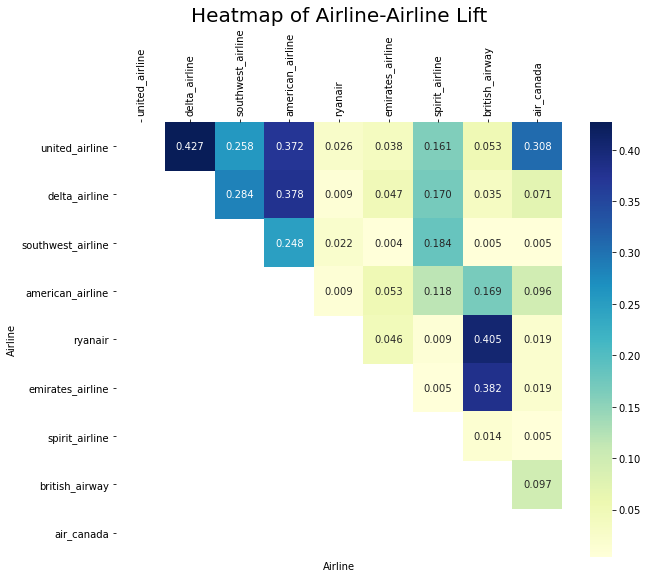

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Airline Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(airline_lift_df, cmap = "YlGnBu", annot = True, fmt='.3f')

In [51]:
airline_dissimi_df = pd.DataFrame(data=airline_dissimi_array, index=airline_count_df['Airline'], columns=airline_count_df['Airline'])
airline_dissimi_df

Airline,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada
Airline,,,,,,,,,
united_airline,0.000,2.342,3.876,2.688,38.462,26.316,6.211,18.868,3.247
delta_airline,2.342,0.000,3.521,2.646,111.111,21.277,5.882,28.571,14.085
southwest_airline,3.876,3.521,0.000,4.032,45.455,250.000,5.435,200.000,200.000
american_airline,2.688,2.646,4.032,0.000,111.111,18.868,8.475,5.917,10.417
ryanair,38.462,111.111,45.455,111.111,0.000,21.739,111.111,2.469,52.632
emirates_airline,26.316,21.277,250.000,18.868,21.739,0.000,200.000,2.618,52.632
spirit_airline,6.211,5.882,5.435,8.475,111.111,200.000,0.000,71.429,200.000
british_airway,18.868,28.571,200.000,5.917,2.469,2.618,71.429,0.000,10.309
air_canada,3.247,14.085,200.000,10.417,52.632,52.632,200.000,10.309,0.000


<AxesSubplot:title={'center':'Heatmap of Airline-Airline Dissimilarity'}, xlabel='Airline', ylabel='Airline'>

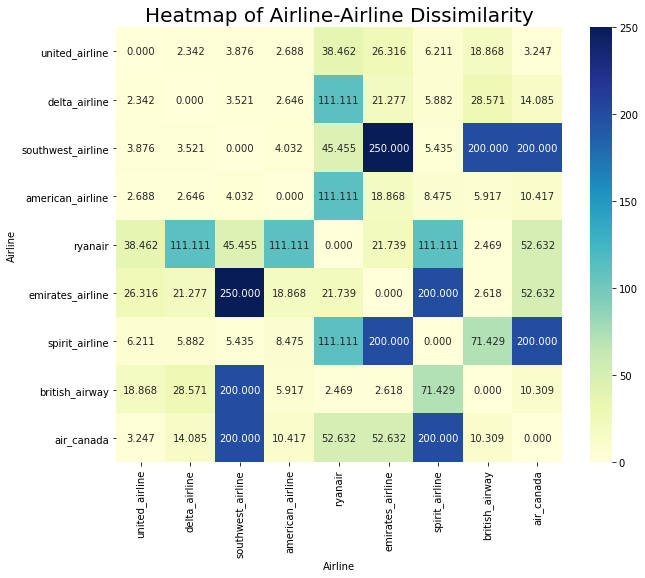

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Airline Dissimilarity', fontsize = 20)
sns.heatmap(airline_dissimi_df, cmap = "YlGnBu", annot = True, fmt='.3f')

## 4.2 Lift ratio between airlines and attributes

In [54]:
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023


In [55]:
attr_count_df

,Attribute Catgory,Count
0,comfort,7587
1,in-flight_entertainment,1883
2,customer_service,14411
3,monetary_values,11603
4,cleanliness,1042
5,check-in_boarding,16956
6,food_beverage,4664


In [56]:
airline_attri_list = pd.concat([airline_count_df.rename(columns={'Airline':'Word'}), 
                                    attr_count_df.rename(columns={'Attribute Catgory':'Word'})], 
                                   ignore_index=True)
airline_attri_list

,Word,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023
9,comfort,7587


In [65]:
df_airline_attri_final

,Airline_Mentioned,Attribute_Mentioned,Merge
0,[delta_airline],[comfort],"[delta_airline, comfort]"
1,[delta_airline],"[check-in_boarding, customer_service, monetary...","[delta_airline, check-in_boarding, customer_se..."
2,[delta_airline],[check-in_boarding],"[delta_airline, check-in_boarding]"
3,[delta_airline],"[check-in_boarding, monetary_values]","[delta_airline, check-in_boarding, monetary_va..."
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]","[delta_airline, comfort, check-in_boarding, mo..."
...,...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,...","[british_airway, check-in_boarding, customer_s..."
19996,[british_airway],[customer_service],"[british_airway, customer_service]"
19997,[british_airway],"[comfort, cleanliness, customer_service, food_...","[british_airway, comfort, cleanliness, custome..."
19998,[british_airway],[customer_service],"[british_airway, customer_service]"


In [66]:
df_airline_attri_final['Merge'] = df_airline_attri_final['Airline_Mentioned'] + df_airline_attri_final['Attribute_Mentioned']
df_airline_attri_final

,Airline_Mentioned,Attribute_Mentioned,Merge
0,[delta_airline],[comfort],"[delta_airline, comfort]"
1,[delta_airline],"[check-in_boarding, customer_service, monetary...","[delta_airline, check-in_boarding, customer_se..."
2,[delta_airline],[check-in_boarding],"[delta_airline, check-in_boarding]"
3,[delta_airline],"[check-in_boarding, monetary_values]","[delta_airline, check-in_boarding, monetary_va..."
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]","[delta_airline, comfort, check-in_boarding, mo..."
...,...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,...","[british_airway, check-in_boarding, customer_s..."
19996,[british_airway],[customer_service],"[british_airway, customer_service]"
19997,[british_airway],"[comfort, cleanliness, customer_service, food_...","[british_airway, comfort, cleanliness, custome..."
19998,[british_airway],[customer_service],"[british_airway, customer_service]"


In [76]:
airline_attr_lift_array = np.empty((len(airline_attri_list),len(airline_attri_list)))
airline_attr_lift_array[:] = np.NaN

In [68]:
N = len(review) # total number of reviews
N

20000

In [77]:
for i in range(len(airline_attri_list)): 
    word1 = airline_attri_list['Word'][i]
    word1_count =  airline_attri_list['Count'][i] # number of reviews containing word 1
    
    for j in range(i+1, len(airline_attri_list)):
        word2 = airline_attri_list['Word'][j]
        word2_count = airline_attri_list['Count'][j] # number of reviews containing word 2
        
        word1_2_count = 0 # number of reviews containing both word 1 and 2
        for words in df_airline_attri_final['Merge']:
            if word1 in words and word2 in words:
                word1_2_count += 1
                
        airline_attr_lift = N*word1_2_count/(word1_count*word2_count) # calculate lift
        airline_attr_lift_array[i,j] = airline_attr_lift

In [88]:
airline_attr_lift_array = np.round(airline_attr_lift_array, decimals=3)
airline_attr_lift_array

array([[  nan, 0.415, 0.254, 0.36 , 0.026, 0.034, 0.161, 0.053, 0.308,
        0.674, 0.317, 0.963, 0.918, 0.427, 0.99 , 0.376],
       [  nan,   nan, 0.284, 0.357, 0.009, 0.043, 0.17 , 0.035, 0.071,
        0.661, 0.242, 0.858, 0.958, 0.352, 0.982, 0.278],
       [  nan,   nan,   nan, 0.248, 0.022, 0.004, 0.184, 0.005, 0.005,
        0.809, 0.337, 0.97 , 1.019, 0.883, 0.975, 0.478],
       [  nan,   nan,   nan,   nan, 0.009, 0.053, 0.118, 0.169, 0.096,
        0.72 , 0.301, 0.946, 0.949, 0.392, 0.99 , 0.336],
       [  nan,   nan,   nan,   nan,   nan, 0.046, 0.009, 0.405, 0.019,
        1.204, 0.494, 1.008, 1.187, 1.454, 1.079, 0.886],
       [  nan,   nan,   nan,   nan,   nan,   nan, 0.005, 0.382, 0.019,
        1.764, 3.556, 1.217, 0.739, 2.007, 0.956, 2.758],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.014, 0.005,
        0.633, 0.181, 0.854, 1.29 , 0.374, 1.012, 0.384],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.097,
        1.823, 2.803, 1.16

In [90]:
airline_attr_dissimi_array = 1/airline_attr_lift_array # calculate dissimilarity for MDS plot
np.nan_to_num(airline_attr_dissimi_array, copy=False, nan=0.0)
airline_attr_dissimi_array = airline_attr_dissimi_array + airline_attr_dissimi_array.T  # fill the lower triangular part
airline_attr_dissimi_array = np.round(airline_attr_dissimi_array, decimals=3)
airline_attr_dissimi_array

array([[  0.   ,   2.41 ,   3.937,   2.778,  38.462,  29.412,   6.211,
         18.868,   3.247,   1.484,   3.155,   1.038,   1.089,   2.342,
          1.01 ,   2.66 ],
       [  2.41 ,   0.   ,   3.521,   2.801, 111.111,  23.256,   5.882,
         28.571,  14.085,   1.513,   4.132,   1.166,   1.044,   2.841,
          1.018,   3.597],
       [  3.937,   3.521,   0.   ,   4.032,  45.455, 250.   ,   5.435,
        200.   , 200.   ,   1.236,   2.967,   1.031,   0.981,   1.133,
          1.026,   2.092],
       [  2.778,   2.801,   4.032,   0.   , 111.111,  18.868,   8.475,
          5.917,  10.417,   1.389,   3.322,   1.057,   1.054,   2.551,
          1.01 ,   2.976],
       [ 38.462, 111.111,  45.455, 111.111,   0.   ,  21.739, 111.111,
          2.469,  52.632,   0.831,   2.024,   0.992,   0.842,   0.688,
          0.927,   1.129],
       [ 29.412,  23.256, 250.   ,  18.868,  21.739,   0.   , 200.   ,
          2.618,  52.632,   0.567,   0.281,   0.822,   1.353,   0.498,
          1.0

In [92]:
airline_attr_lift_df = pd.DataFrame(data=airline_attr_lift_array, 
                                  index=airline_attri_list['Word'], columns=airline_attri_list['Word'])
airline_attr_lift_df

Word,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada,comfort,in-flight_entertainment,customer_service,monetary_values,cleanliness,check-in_boarding,food_beverage
Word,,,,,,,,,,,,,,,,
united_airline,NaN,0.415,0.254,0.360,0.026,0.034,0.161,0.053,0.308,0.674,0.317,0.963,0.918,0.427,0.990,0.376
delta_airline,NaN,NaN,0.284,0.357,0.009,0.043,0.170,0.035,0.071,0.661,0.242,0.858,0.958,0.352,0.982,0.278
southwest_airline,NaN,NaN,NaN,0.248,0.022,0.004,0.184,0.005,0.005,0.809,0.337,0.970,1.019,0.883,0.975,0.478
american_airline,NaN,NaN,NaN,NaN,0.009,0.053,0.118,0.169,0.096,0.720,0.301,0.946,0.949,0.392,0.990,0.336
ryanair,NaN,NaN,NaN,NaN,NaN,0.046,0.009,0.405,0.019,1.204,0.494,1.008,1.187,1.454,1.079,0.886
emirates_airline,NaN,NaN,NaN,NaN,NaN,NaN,0.005,0.382,0.019,1.764,3.556,1.217,0.739,2.007,0.956,2.758
spirit_airline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014,0.005,0.633,0.181,0.854,1.290,0.374,1.012,0.384
british_airway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097,1.823,2.803,1.168,0.969,2.518,0.994,2.817
air_canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200,1.764,1.105,0.872,1.338,1.003,1.528


<AxesSubplot:title={'center':'Heatmap of Airline-Attribute Lift'}, xlabel='Word', ylabel='Word'>

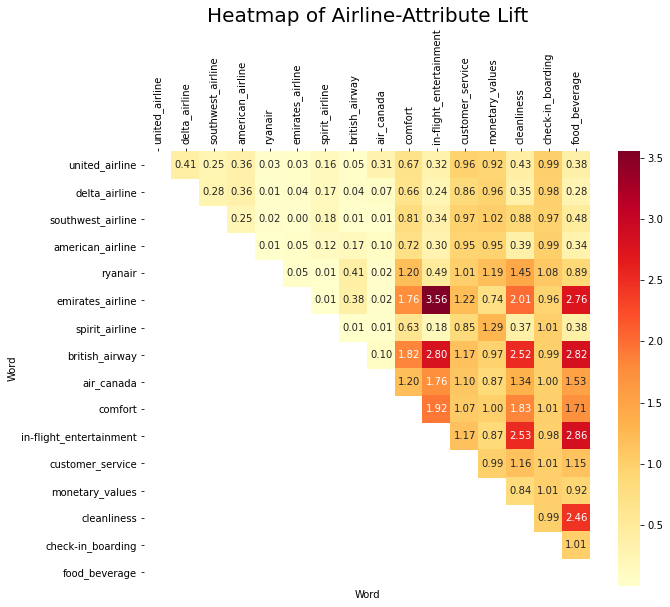

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Attribute Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(airline_attr_lift_df, cmap = 'YlOrRd', annot = True, fmt='.2f')

In [94]:
airline_attr_dissimi_df = pd.DataFrame(data=airline_attr_dissimi_array, 
                                     index=airline_attri_list['Word'], columns=airline_attri_list['Word'])
airline_attr_dissimi_df

Word,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada,comfort,in-flight_entertainment,customer_service,monetary_values,cleanliness,check-in_boarding,food_beverage
Word,,,,,,,,,,,,,,,,
united_airline,0.000,2.410,3.937,2.778,38.462,29.412,6.211,18.868,3.247,1.484,3.155,1.038,1.089,2.342,1.010,2.660
delta_airline,2.410,0.000,3.521,2.801,111.111,23.256,5.882,28.571,14.085,1.513,4.132,1.166,1.044,2.841,1.018,3.597
southwest_airline,3.937,3.521,0.000,4.032,45.455,250.000,5.435,200.000,200.000,1.236,2.967,1.031,0.981,1.133,1.026,2.092
american_airline,2.778,2.801,4.032,0.000,111.111,18.868,8.475,5.917,10.417,1.389,3.322,1.057,1.054,2.551,1.010,2.976
ryanair,38.462,111.111,45.455,111.111,0.000,21.739,111.111,2.469,52.632,0.831,2.024,0.992,0.842,0.688,0.927,1.129
emirates_airline,29.412,23.256,250.000,18.868,21.739,0.000,200.000,2.618,52.632,0.567,0.281,0.822,1.353,0.498,1.046,0.363
spirit_airline,6.211,5.882,5.435,8.475,111.111,200.000,0.000,71.429,200.000,1.580,5.525,1.171,0.775,2.674,0.988,2.604
british_airway,18.868,28.571,200.000,5.917,2.469,2.618,71.429,0.000,10.309,0.549,0.357,0.856,1.032,0.397,1.006,0.355
air_canada,3.247,14.085,200.000,10.417,52.632,52.632,200.000,10.309,0.000,0.833,0.567,0.905,1.147,0.747,0.997,0.654


<AxesSubplot:title={'center':'Heatmap of Airline-Attribute Dissimilarity'}, xlabel='Word', ylabel='Word'>

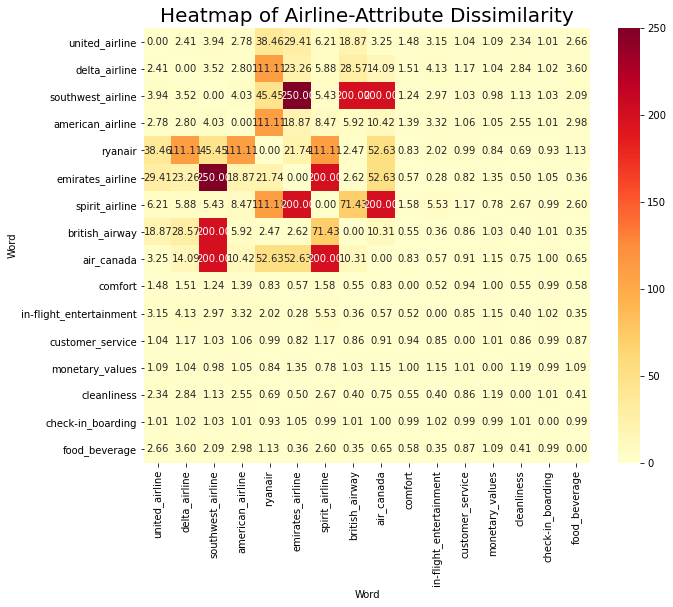

In [95]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Attribute Dissimilarity', fontsize = 20)
sns.heatmap(airline_attr_dissimi_df, cmap = 'YlOrRd', annot = True, fmt='.2f')